## Import CNN/Daily Mail Dataset

In [1]:
from datasets import load_dataset
from utils.sample import sample, print_sample
import torch
import nltk
nltk.download('stopwords')
import os

corpus = load_dataset("cnn_dailymail", "3.0.0")
train_corpus = corpus["train"]
test_corpus = corpus["test"]

example = sample(train_corpus)
print_sample(example, max_chars=200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jackeinbinder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Article:
"(CNN) -- A magnitude 7.9 earthquake struck off the coast of central Peru on Wednesday evening, killing 15 people and leaving 70 hurt, President Alan Garcia said on national television. Pedestrians tr...

Highlights:
"NEW: Tsunami warnings and watches canceled, as is Hawaii's advisory .\nAt least 15 people killed, 70 injured in quake .\nQuake was felt for two minutes; people ran out of office buildings in panic .\...

Id:
"fca2c956e45391f8b205cbe78e6b454321d49305"



## Compare BART and PEGASUS models

### Select Samples

In [2]:
# Select 100 articles
NUM_SAMPLES = 100
articles = sample(test_corpus, NUM_SAMPLES)

### Import Models

In [3]:
from utils.pipeline import make_bart_pipeline, make_pegasus_pipeline

bart = make_bart_pipeline()
pegasus = make_pegasus_pipeline()

Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


### Prepare Summarizers

In [4]:
from core.summarizer import Summarizer

model_configs = {
    'bart': Summarizer(bart),
    'pegasus': Summarizer(pegasus)
}

### Generate & Evaluate Summaries

Evaluating: BART...

Generating summaries for 100 articles...

Completed in 00:11:002.04


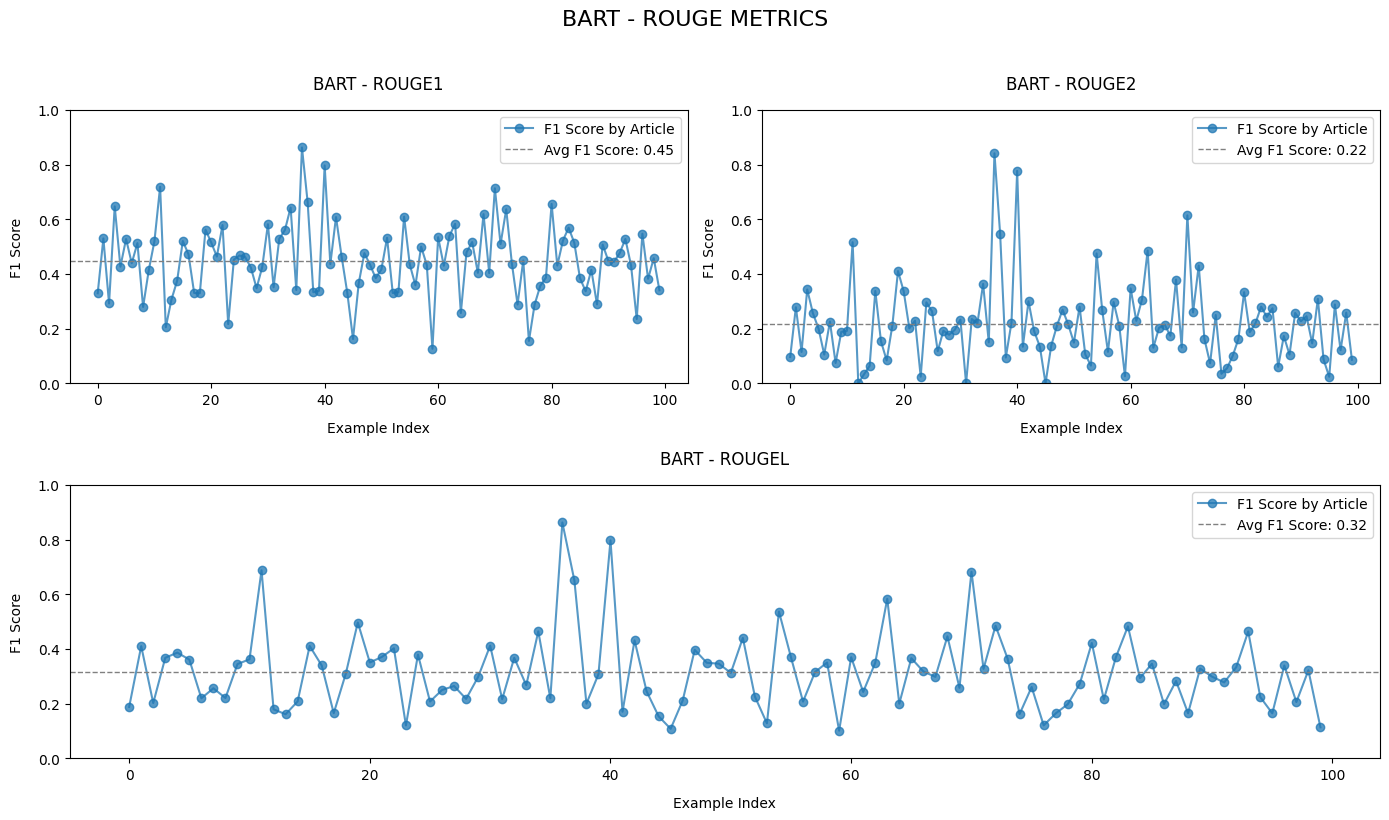

Evaluating: PEGASUS...

Generating summaries for 100 articles...

Completed in 00:15:034.55


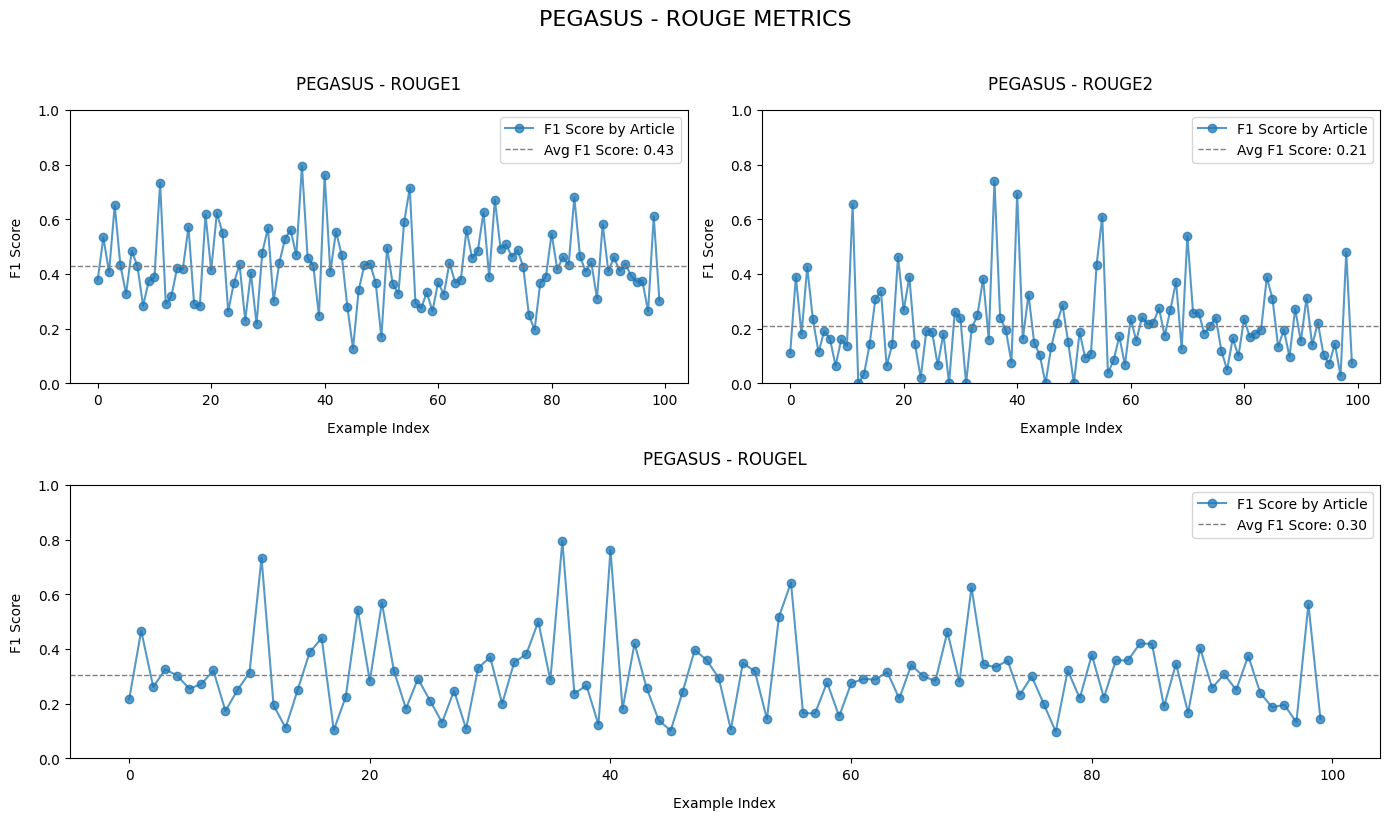

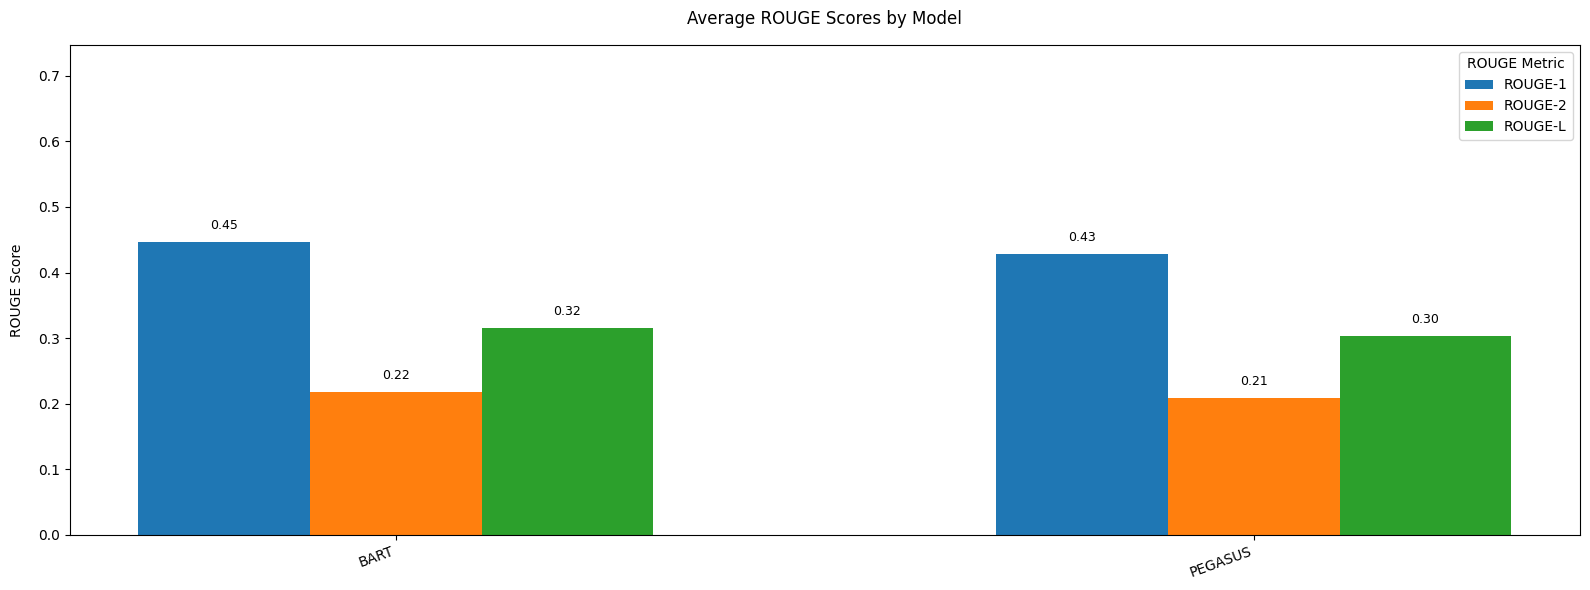

In [5]:
from utils.sum_eval import sum_eval
from utils.plot import plot_avg_rouge, plot_avg_manual_score
import pandas as pd

results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)

model_scores = sum_eval(articles, model_configs)
df_models = pd.DataFrame(model_scores).T.sort_values(by='rougeL', ascending=False)

plot_avg_rouge(model_scores, save_path=os.path.join(results_dir, 'avg_rouge_scores'))

### Extrinsic Evaluation

In [6]:
# Select 10 articles
NUM_RANDOM_SAMPLES = 10
manual_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

In [7]:
# Generate summaries
bart_summarizer = model_configs['bart']
bart_summaries = bart_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:012.57


##### BART

In [8]:
from evaluation.extrinsic_evaluator import ExtrinsicEvaluator

# Evaluate Bart
bart_evaluator = ExtrinsicEvaluator(bart_summaries)
bart_evaluator.evaluate('BART')
bart_id_to_score = {
    "432642e19523c71e986985b0a1bb82f6baa9dc4f": 5,
    "15fffd5f6e0249a50b8ff64afa785a56e3cd6329": 5,
    "a4f3403c0c05589f939d0f4ddb138e8e2c5d288e": 5,
    "bc526b7c50b3b816751a6a692cdb7324d980a576": 5,
    "ca5cf6768d5700c8e944d7ec773d2116075d9003": 5,
    "41722a8d14392fd2999bafbcec86f04d5634590f": 5,
    "85afff41a6d8d564588c54c6b5b9ff972dfe0eff": 5,
    "868be1a9da96d8ddbc357599943293a7684eb271": 5,
    "197354baef143a117e28c3d7e6497fe3f08c975f": 5,
    "f9b726faba76c1808f033491ef21960438ce5914": 5,
}
bart_evaluator.submit_scores(bart_id_to_score)


Manually evaluating BART...
ID: b02798e17147839d052ead06f9be7674d6ab5a8d
Article:
Following all his inspired charity work, Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. The 37-year-old, who scored against Leicester on Wednesday, spoke in the video about his experiences growing up in the Ivory Coast and his love for football. Didier Drogba with the Barclays Spirit of the Game award following all the charity work he's done in Africa . The Ivorian scored the equaliser for Chelsea against Leicester on Wednesday, his seventh of the season . He said 'I come from a poor family where I played football in the streets with my friends with no shoes, there was no grass but we still enjoyed it. 'There is nothing better than when you see a kid with a smile on his face and that is why I'm trying to help. I w

##### PEGASUS

In [9]:
# Generate Summaries
pegasus_summarizer = model_configs['pegasus']
pegasus_summaries = pegasus_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:038.63


In [10]:
# Evaluate PEGASUS
pegasus_evaluator = ExtrinsicEvaluator(pegasus_summaries)
pegasus_evaluator.evaluate('PEGASUS')
pegasus_id_to_score = {
    "432642e19523c71e986985b0a1bb82f6baa9dc4f": 5,
    "15fffd5f6e0249a50b8ff64afa785a56e3cd6329": 5,
    "a4f3403c0c05589f939d0f4ddb138e8e2c5d288e": 5,
    "bc526b7c50b3b816751a6a692cdb7324d980a576": 5,
    "ca5cf6768d5700c8e944d7ec773d2116075d9003": 5,
    "41722a8d14392fd2999bafbcec86f04d5634590f": 5,
    "85afff41a6d8d564588c54c6b5b9ff972dfe0eff": 5,
    "868be1a9da96d8ddbc357599943293a7684eb271": 5,
    "197354baef143a117e28c3d7e6497fe3f08c975f": 5,
    "f9b726faba76c1808f033491ef21960438ce5914": 5,
}
pegasus_evaluator.submit_scores(pegasus_id_to_score)

Manually evaluating PEGASUS...
ID: b02798e17147839d052ead06f9be7674d6ab5a8d
Article:
Following all his inspired charity work, Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. The 37-year-old, who scored against Leicester on Wednesday, spoke in the video about his experiences growing up in the Ivory Coast and his love for football. Didier Drogba with the Barclays Spirit of the Game award following all the charity work he's done in Africa . The Ivorian scored the equaliser for Chelsea against Leicester on Wednesday, his seventh of the season . He said 'I come from a poor family where I played football in the streets with my friends with no shoes, there was no grass but we still enjoyed it. 'There is nothing better than when you see a kid with a smile on his face and that is why I'm trying to help. 

#### Plot Manual Scores

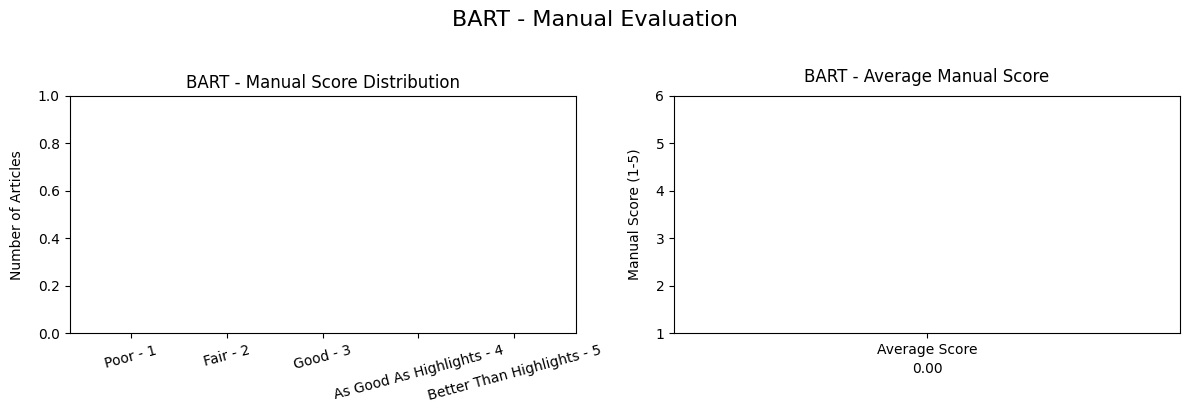

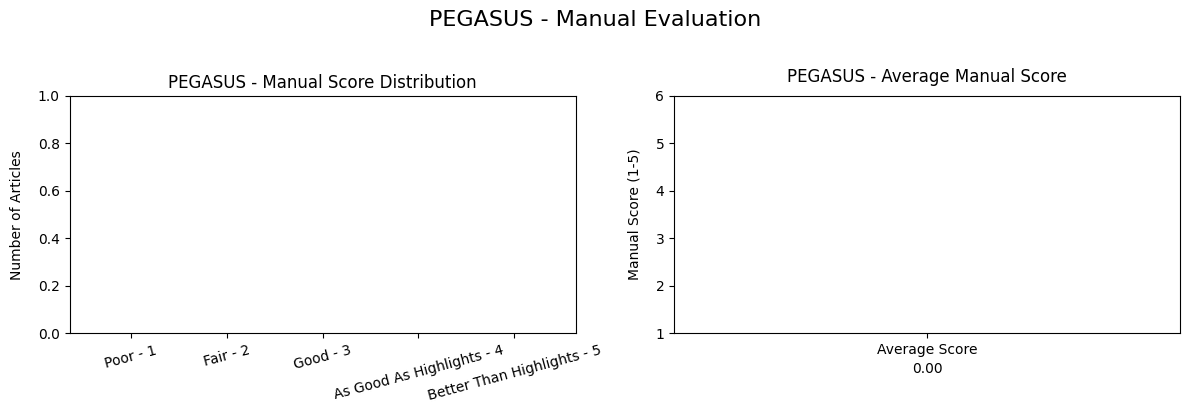

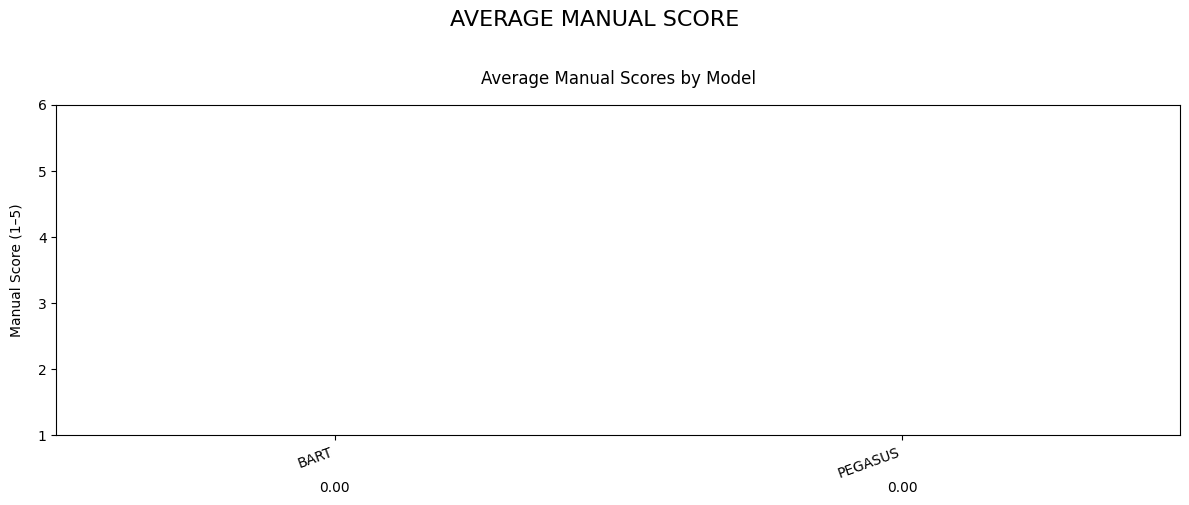

In [11]:
bart_evaluator.plot('BART', save_path=os.path.join(results_dir, 'bart'))
pegasus_evaluator.plot('PEGASUS', save_path=os.path.join(results_dir, 'pegasus'))

avg_manual_scores = {
    'bart': bart_evaluator.avg_score,
    'pegasus': pegasus_evaluator.avg_score
}

plot_avg_manual_score(avg_manual_scores, save_path=os.path.join(results_dir, 'avg_manual_scores'))

#### Winner is BART

## Ablation Study

### Hyperparameter Strategies

In [12]:
from utils.pipeline import make_bart_pipeline

bart_default = make_bart_pipeline(
    
)

bart_beam_light = make_bart_pipeline(
    num_beams=4,
    early_stopping=True
)

bart_beam = make_bart_pipeline(
    num_beams=8,
    early_stopping=True
)

bart_short = make_bart_pipeline(
    max_length=60,
    min_length=20
)

bart_sample_basic = make_bart_pipeline(
    do_sample=True
)

bart_sample_temp = make_bart_pipeline(
    do_sample=True,
    temperature=0.7
)

bart_sample_topk = make_bart_pipeline(
    do_sample=True,
    top_k=50,
    temperature=0.8
)

bart_sample_topp = make_bart_pipeline(
    do_sample=True,
    top_p=0.92,
    temperature=0.8
)

bart_sample_topkp = make_bart_pipeline(
    do_sample=True,
    top_k=50,
    top_p=0.92,
    temperature=0.8
)


Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


### Prepare Summarizers

In [13]:
ablation_configs = {
    'bart_default': Summarizer(bart_default),
    'bart_beam_light': Summarizer(bart_beam_light),
    'bart_beam': Summarizer(bart_beam),
    'bart_short': Summarizer(bart_short),
    'bart_sample_basic': Summarizer(bart_sample_basic),
    'bart_sample_temp': Summarizer(bart_sample_temp),
    'bart_sample_topk': Summarizer(bart_sample_topk),
    'bart_sample_topp': Summarizer(bart_sample_topp),
    'bart_sample_topkp': Summarizer(bart_sample_topkp),
}

### Generate & Evaluate Summaries

Evaluating: BART_DEFAULT...

Generating summaries for 100 articles...

Completed in 00:11:024.63


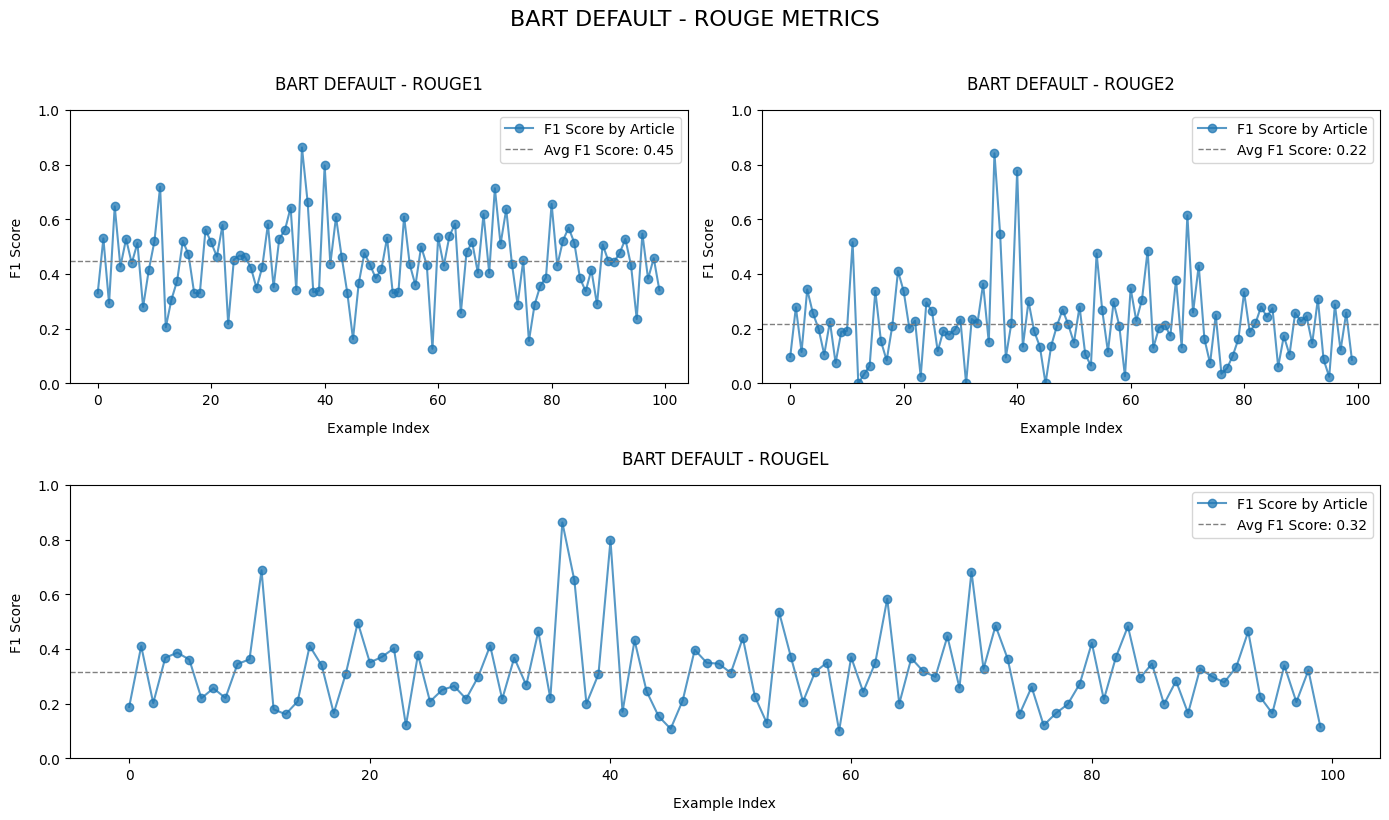

Evaluating: BART_BEAM_LIGHT...

Generating summaries for 100 articles...

Completed in 00:11:004.46


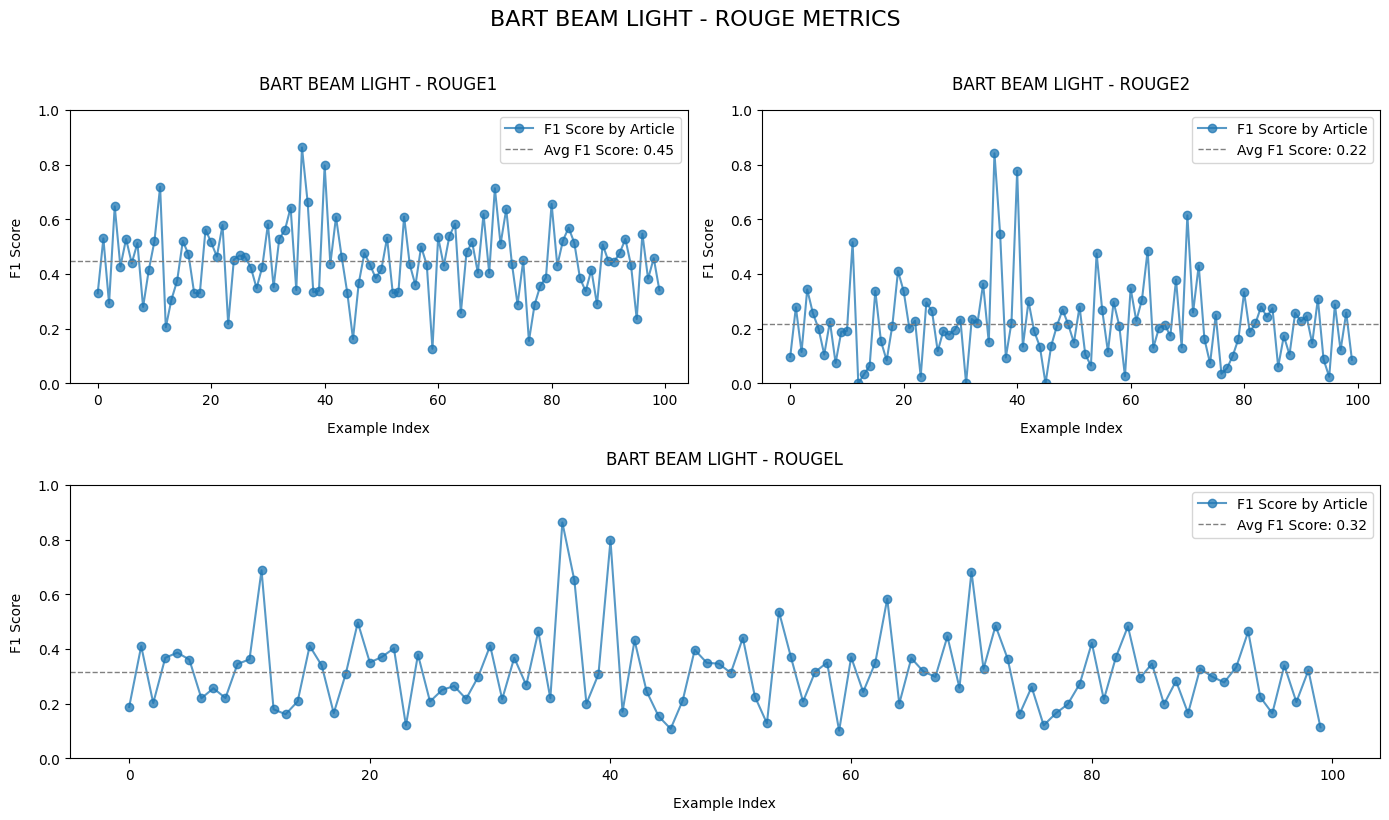

Evaluating: BART_BEAM...

Generating summaries for 100 articles...

Completed in 00:11:000.02


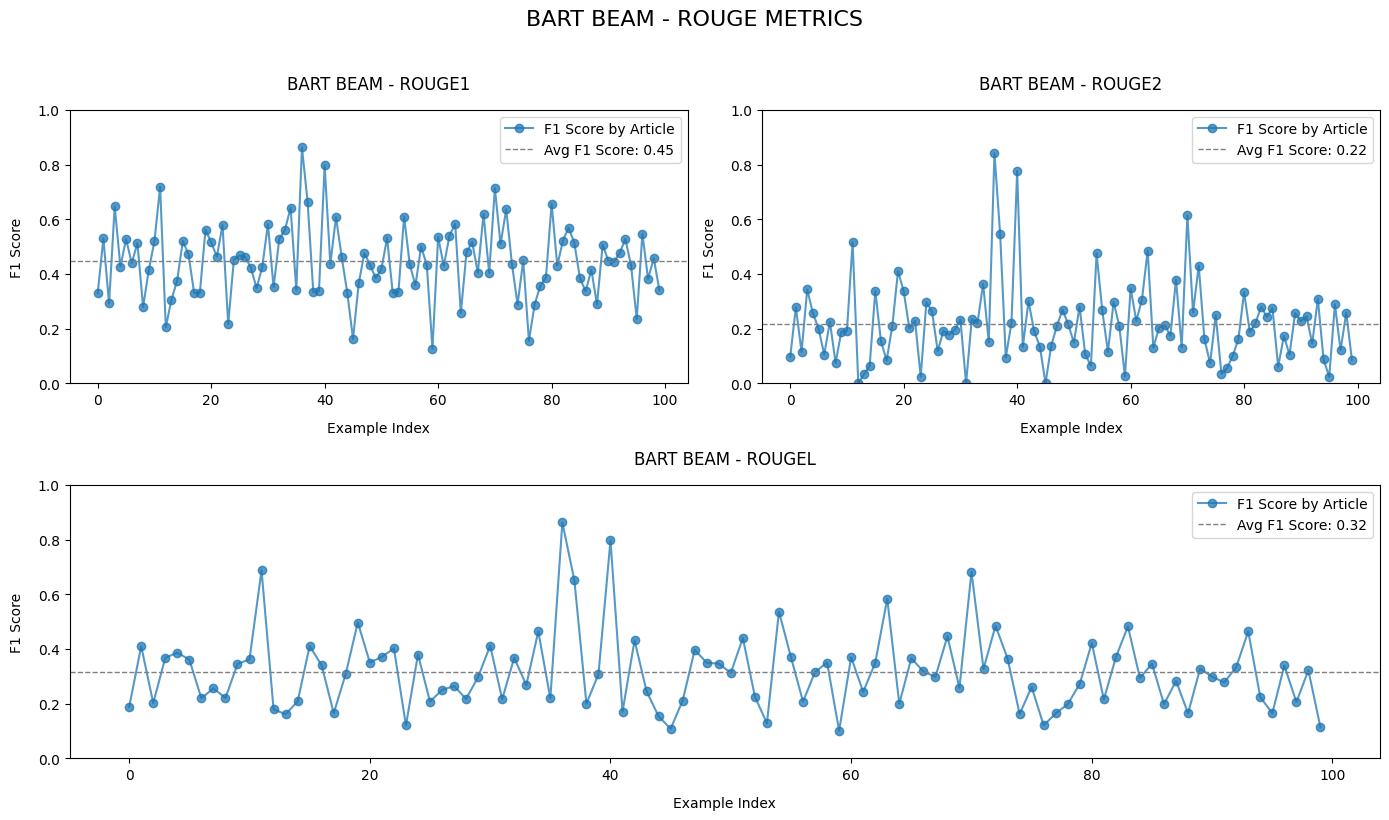

Evaluating: BART_SHORT...

Generating summaries for 100 articles...

Completed in 00:10:056.95


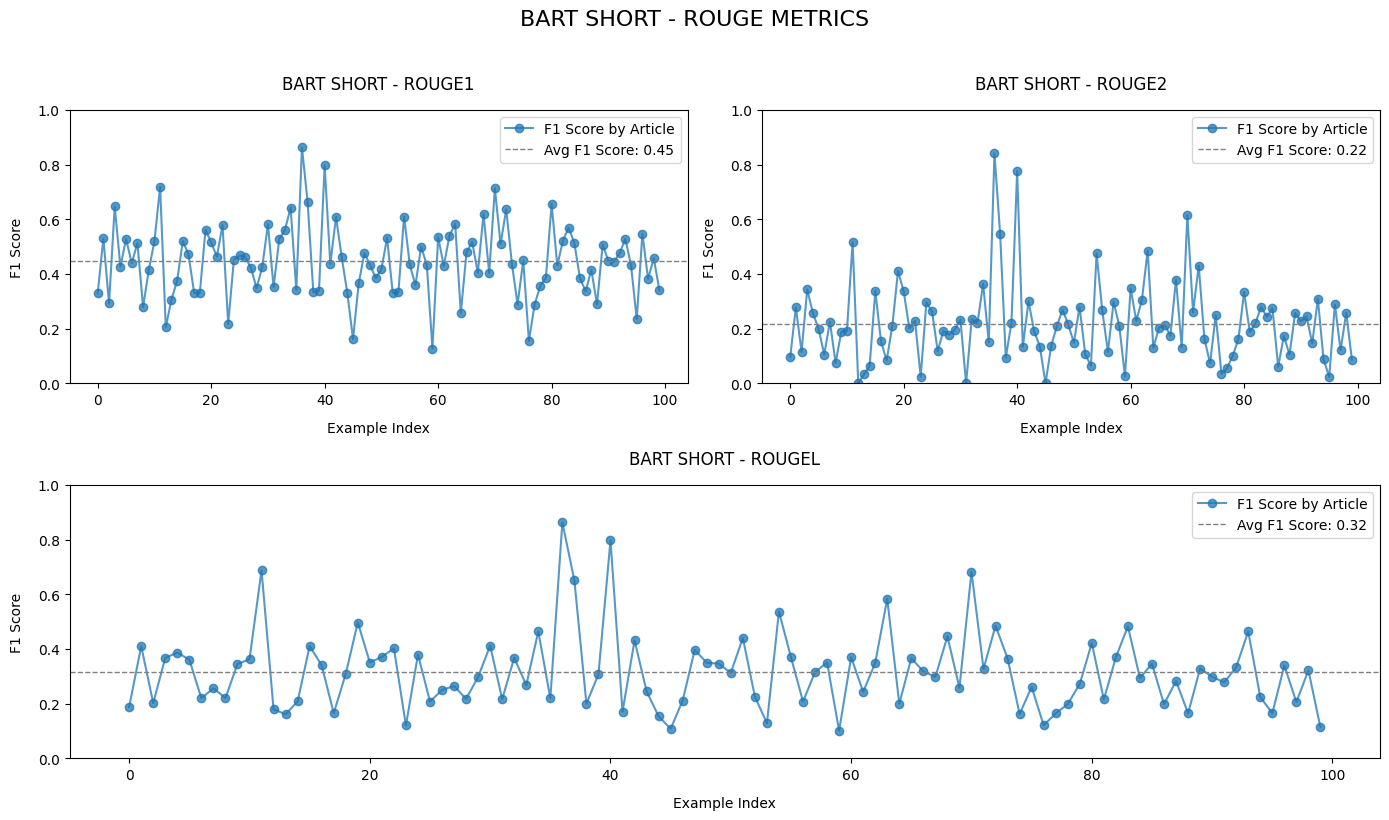

Evaluating: BART_SAMPLE_BASIC...

Generating summaries for 100 articles...

Completed in 00:12:004.09


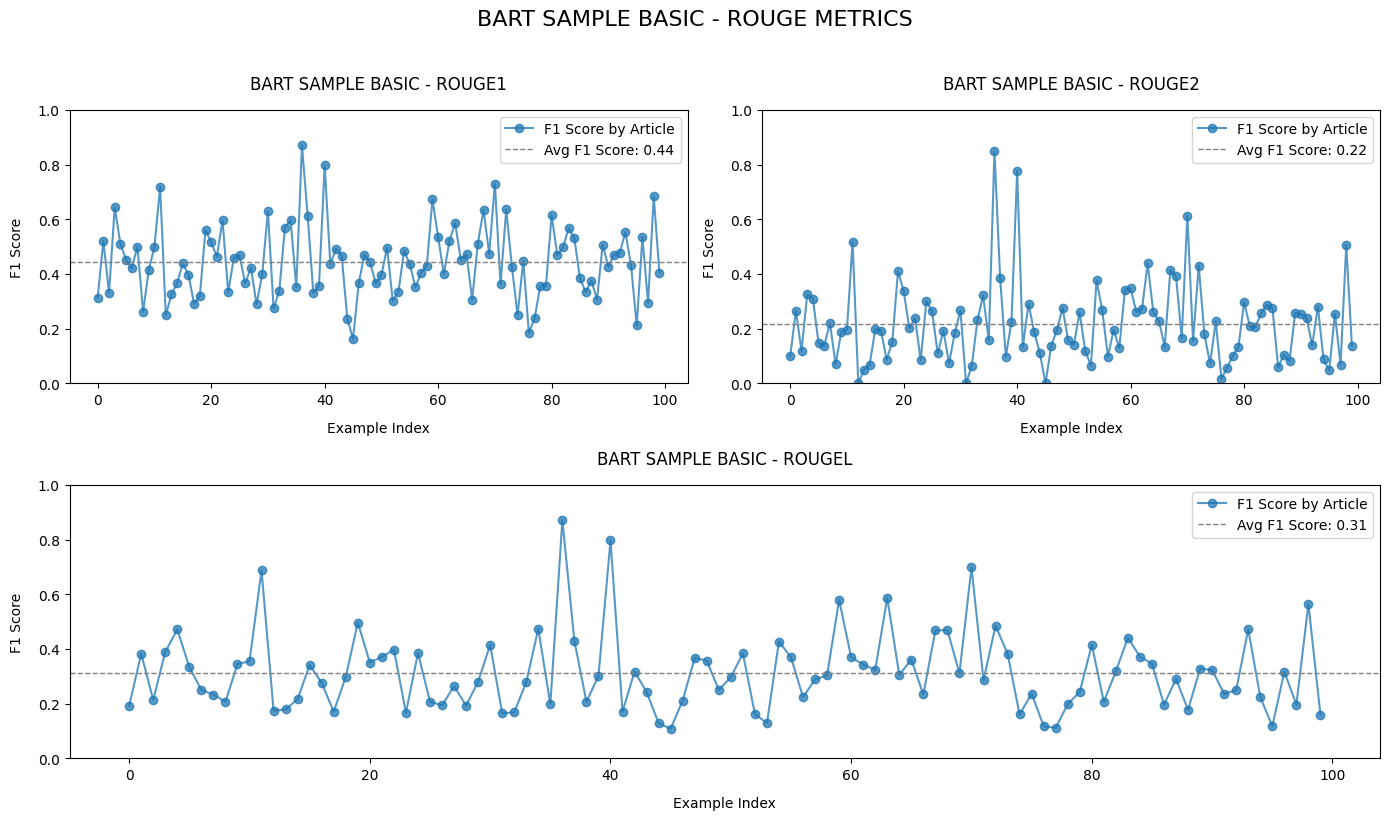

Evaluating: BART_SAMPLE_TEMP...

Generating summaries for 100 articles...

Completed in 00:11:048.53


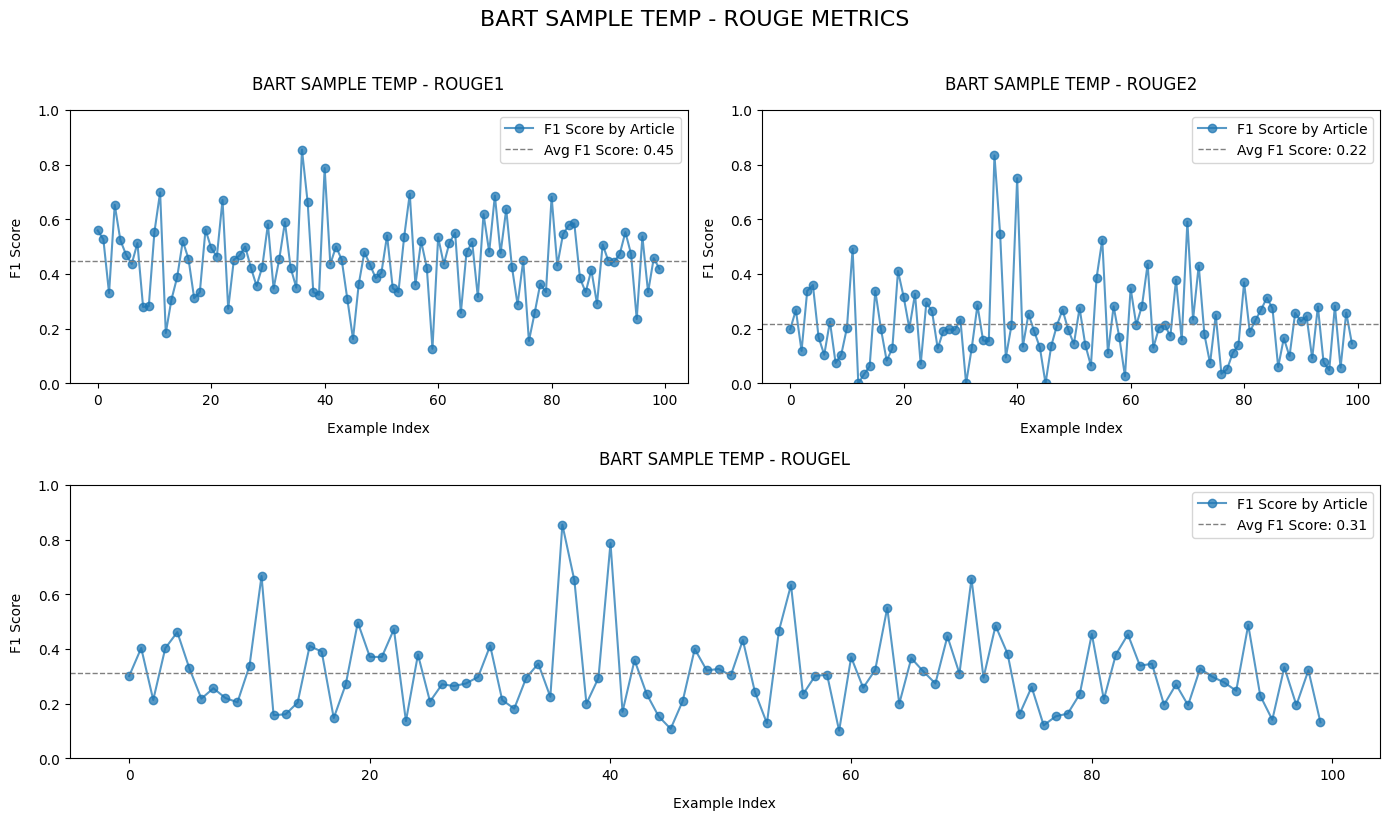

Evaluating: BART_SAMPLE_TOPK...

Generating summaries for 100 articles...

Completed in 00:12:009.12


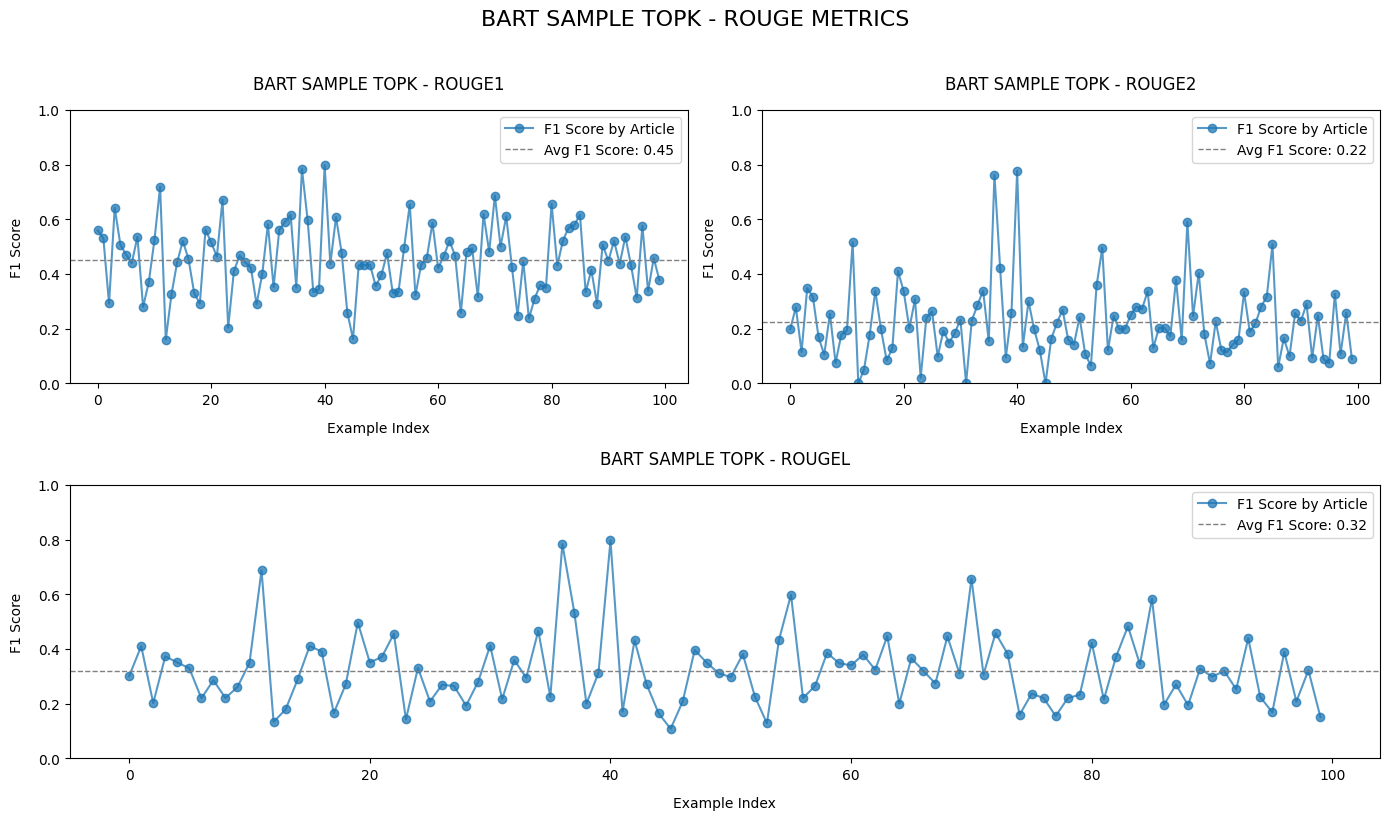

Evaluating: BART_SAMPLE_TOPP...

Generating summaries for 100 articles...

Completed in 00:12:001.41


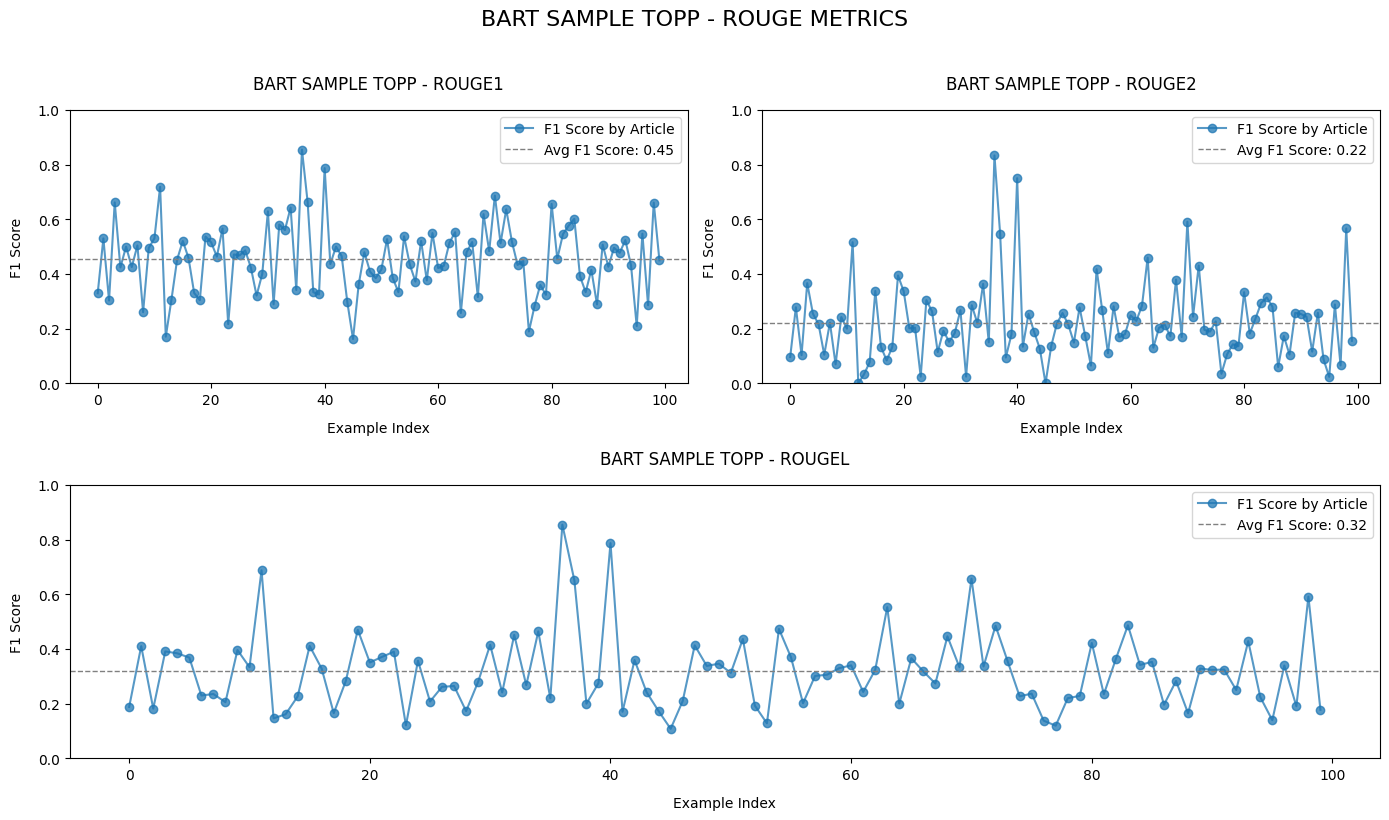

Evaluating: BART_SAMPLE_TOPKP...

Generating summaries for 100 articles...

Completed in 00:12:005.26


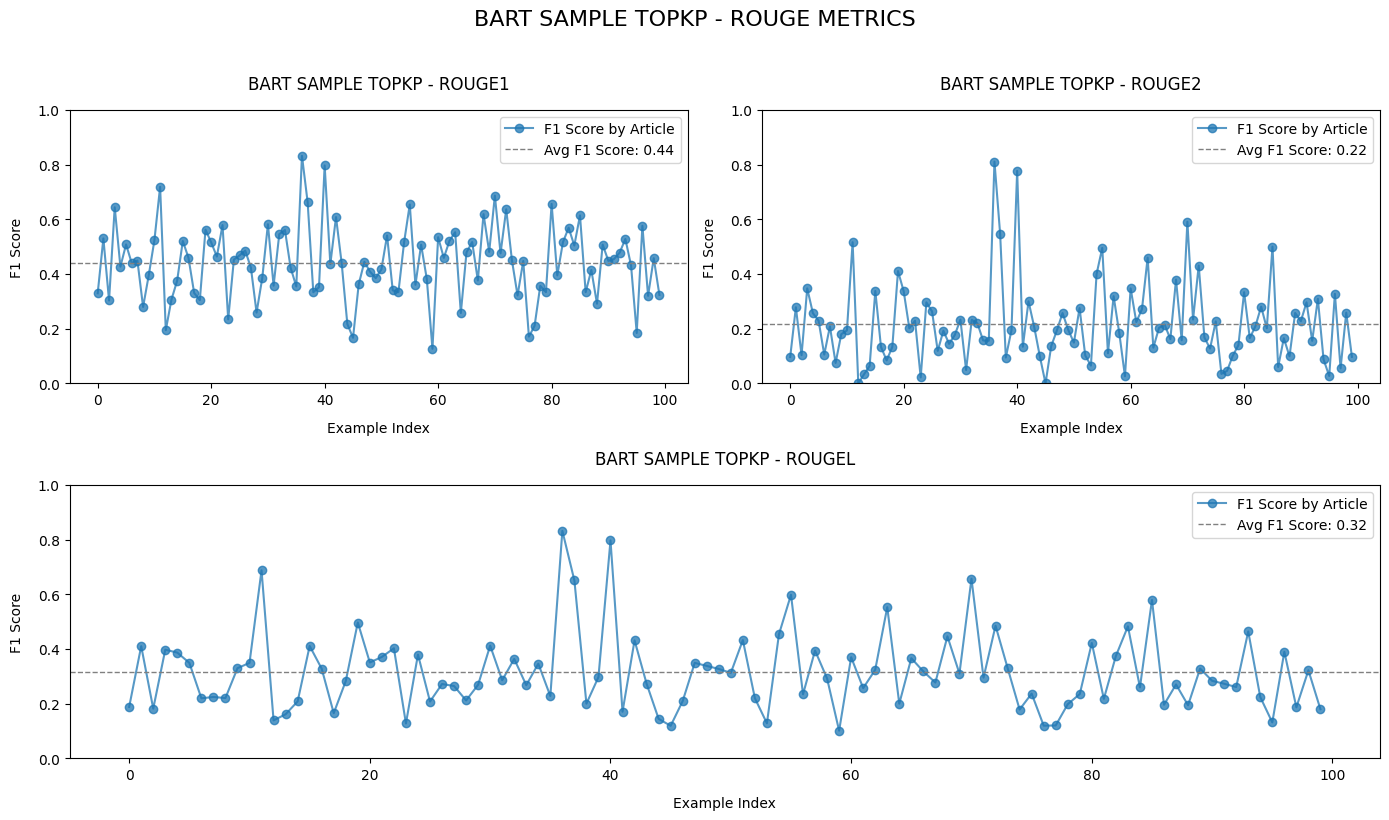

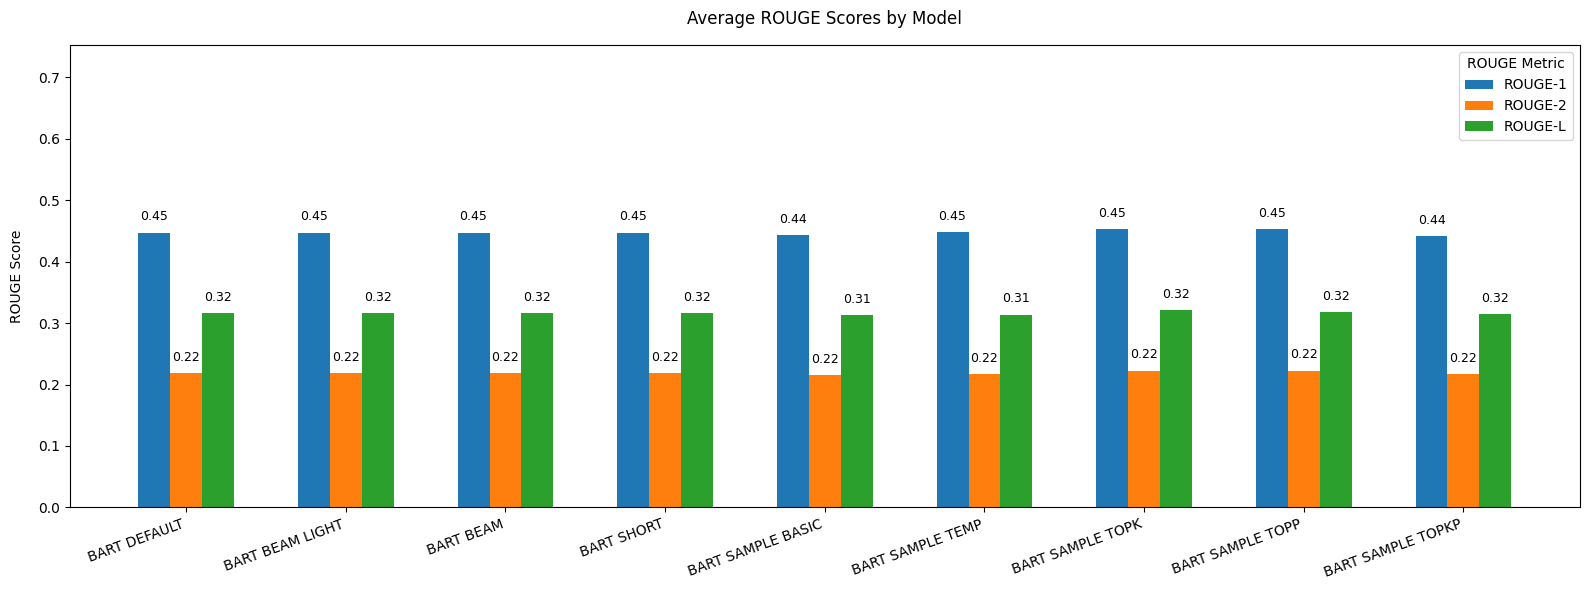

In [14]:
ablation_scores = sum_eval(articles, ablation_configs)
df_ablation = pd.DataFrame(ablation_scores).T.sort_values(by='rougeL', ascending=False)
plot_avg_rouge(ablation_scores, save_path=os.path.join(results_dir, 'ablation_avg_rouge_scores'))

#### Manual Evaluation



In [15]:
# Select 3 random articles
NUM_RANDOM_SAMPLES = 3
manual_ablation_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

##### BART DEFAULT

In [16]:
bart_default_summarizer = ablation_configs['bart_default']
bart_default_summaries = bart_default_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:016.65


In [17]:
# Evaluate Bart Default
bart_default_evaluator = ExtrinsicEvaluator(bart_default_summaries)
bart_default_evaluator.evaluate('BART DEFAULT')
bart_default_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_default_evaluator.submit_scores(bart_default_id_to_score)

Manually evaluating BART DEFAULT...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the fail

##### BART BEAM LIGHT

In [18]:
# Generate Summaries
bart_beam_light_summarizer = ablation_configs['bart_beam_light']
bart_beam_light_summaries = bart_beam_light_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:016.41


In [19]:
# Evaluate Bart Light Beam
bart_beam_light_evaluator = ExtrinsicEvaluator(bart_beam_light_summaries)
bart_beam_light_evaluator.evaluate('BART LIGHT BEAM')
bart_beam_light_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_beam_light_evaluator.submit_scores(bart_beam_light_id_to_score)

Manually evaluating BART LIGHT BEAM...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the f

##### BART BEAM

In [20]:
# Generate Summaries
bart_beam_summarizer = ablation_configs['bart_beam']
bart_beam_summaries = bart_beam_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:016.67


In [21]:
# Evaluate Bart Beam
bart_beam_evaluator = ExtrinsicEvaluator(bart_beam_summaries)
bart_beam_evaluator.evaluate('BART BEAM')
bart_beam_id_to_score = {  # Summaries identical to bart beam light
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,  # Identical to bart beam light
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to bart beam light
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to bart beam light
} 
bart_beam_evaluator.submit_scores(bart_beam_id_to_score)

Manually evaluating BART BEAM...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the failed 

##### BART SHORT

In [22]:
# Generate Summaries
bart_short_summarizer = ablation_configs['bart_short']
bart_short_summaries = bart_short_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:016.68


In [23]:
# Evaluate Bart Short
bart_short_evaluator = ExtrinsicEvaluator(bart_short_summaries)
bart_short_evaluator.evaluate('BART SHORT')
bart_short_id_to_score = {  # Identical summaries to bart beam light and bart beam
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_short_evaluator.submit_scores(bart_short_id_to_score)

Manually evaluating BART SHORT...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the failed

##### BART SAMPLE BASIC

In [24]:
# Generate Summaries
bart_sample_basic_summarizer = ablation_configs['bart_sample_basic']
bart_sample_basic_summaries = bart_sample_basic_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:018.20


In [25]:
# Evaluate Bart Sample Basic
# These were almost the same as previous ones, but were slightly shorter and lost some important details

bart_sample_basic_evaluator = ExtrinsicEvaluator(bart_sample_basic_summaries)
bart_sample_basic_evaluator.evaluate('BART SAMPLE BASIC')
bart_sample_basic_id_to_score = {  # First different summaries
    "82d9d60e0360159b6767e0921de88360a93da0f5": 4,  # Almost better than highlights. Doesnt mention loss to Manchester United
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 4,  # Almost identical to previous, but doesn't mention Penny was cleared
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4   # Doesnt mention talks with Aston Villa
}
bart_sample_basic_evaluator.submit_scores(bart_sample_basic_id_to_score)

Manually evaluating BART SAMPLE BASIC...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the

##### BART SAMPLE TEMP

In [26]:
# Generate Summaries
bart_sample_temp_summarizer = ablation_configs['bart_sample_temp']
bart_sample_temp_summaries = bart_sample_temp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:018.66


In [27]:
# Evaluate Bart Sample Basic
bart_sample_temp_evaluator = ExtrinsicEvaluator(bart_sample_temp_summaries)
bart_sample_temp_evaluator.evaluate('BART SAMPLE TEMP')
bart_sample_temp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  # Doesn't mention loss to Manchester United, doesnt finish last thought
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 3,  # Missing details on being cleared. Doesnt finish thought
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4  # Just doesnt mention Aston Villa talks
}
bart_sample_temp_evaluator.submit_scores(bart_sample_temp_id_to_score)

# Not as good as other models. Doesn't always finish sentences. Some details provided are not important

Manually evaluating BART SAMPLE TEMP...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the 

##### BART SAMPLE TOPK

In [28]:
# Generate Summaries
bart_sample_topk_summarizer = ablation_configs['bart_sample_topk']
bart_sample_topk_summaries = bart_sample_topk_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:018.72


In [29]:
# Evaluate Bart Sample TopK
bart_sample_topk_evaluator = ExtrinsicEvaluator(bart_sample_topk_summaries)
bart_sample_topk_evaluator.evaluate('BART SAMPLE TOPK')
bart_sample_topk_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  # Doesn't mention 4-2 loss to Manchester United 
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to bart light beam and bart beam
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to bart light beam and bart beam
}
bart_sample_topk_evaluator.submit_scores(bart_sample_topk_id_to_score)

# Almost as good as other models with some details being lost and a sentence not being completed

Manually evaluating BART SAMPLE TOPK...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the 

##### BART SAMPLE TOPP

In [30]:
# Generate Summaries
bart_sample_topp_summarizer = ablation_configs['bart_sample_topp']
bart_sample_topp_summaries = bart_sample_topp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:018.70


In [31]:
# Evaluate Bart Sample TopP
bart_sample_topp_evaluator = ExtrinsicEvaluator(bart_sample_topp_summaries)
bart_sample_topp_evaluator.evaluate('BART SAMPLE TOPP')
bart_sample_topp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  # Doesn't mention 4-2 loss to Manchester United
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to previous summaries
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4  # Doesn't mention some enquiries
}
bart_sample_topp_evaluator.submit_scores(bart_sample_topp_id_to_score)

# Strong performance with some smaller details missing

Manually evaluating BART SAMPLE TOPP...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the 

##### BART SAMPLE TOPKP

In [32]:
# Generate Summaries
bart_sample_topkp_summarizer = ablation_configs['bart_sample_topkp']
bart_sample_topkp_summaries = bart_sample_topkp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:018.40


In [33]:
# Evaluate Bart Sample Basic
bart_sample_topkp_evaluator = ExtrinsicEvaluator(bart_sample_topkp_summaries)
bart_sample_topkp_evaluator.evaluate('BART SAMPLE TOPKP')
bart_sample_topkp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,  # This is the best one so far, mentioning that City lost on a Sunday
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to other models
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to other models
}
bart_sample_topkp_evaluator.submit_scores(bart_sample_topkp_id_to_score)

# Performed slightly better than the best models

Manually evaluating BART SAMPLE TOPKP...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the

## Manual Evaluation Results

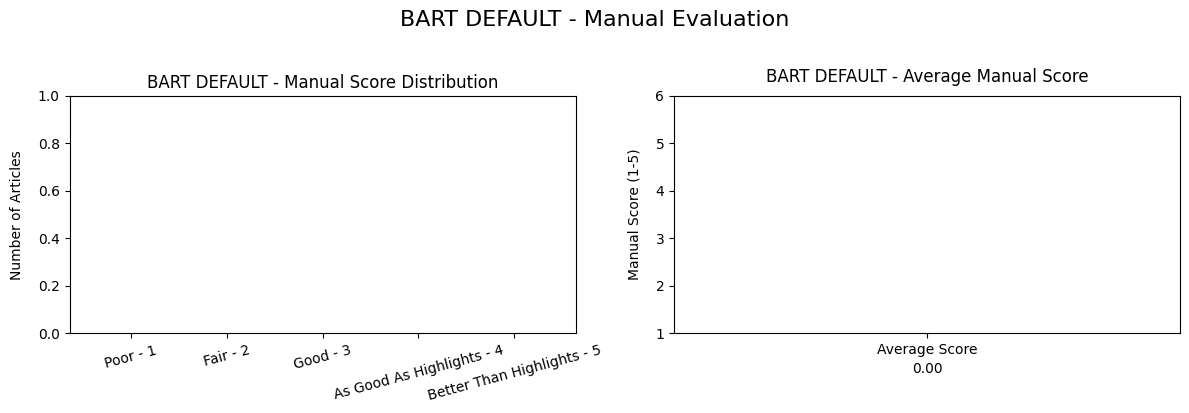

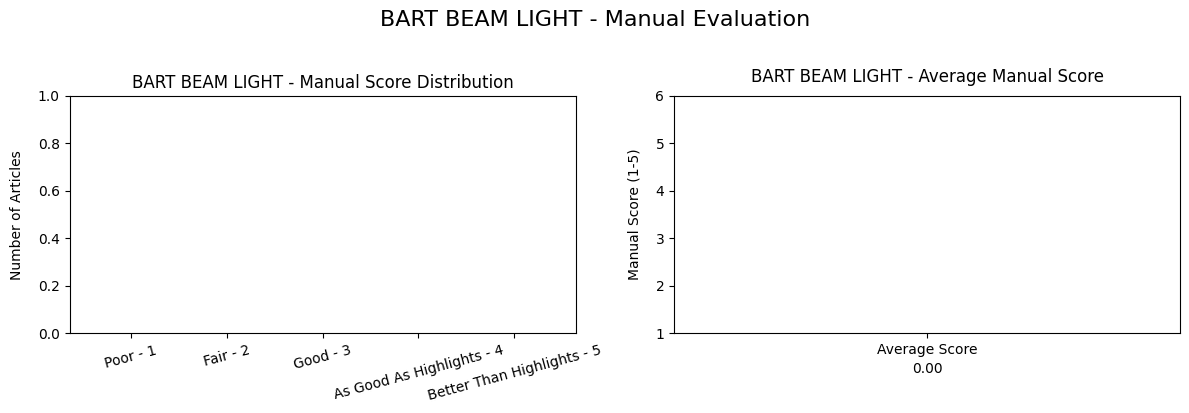

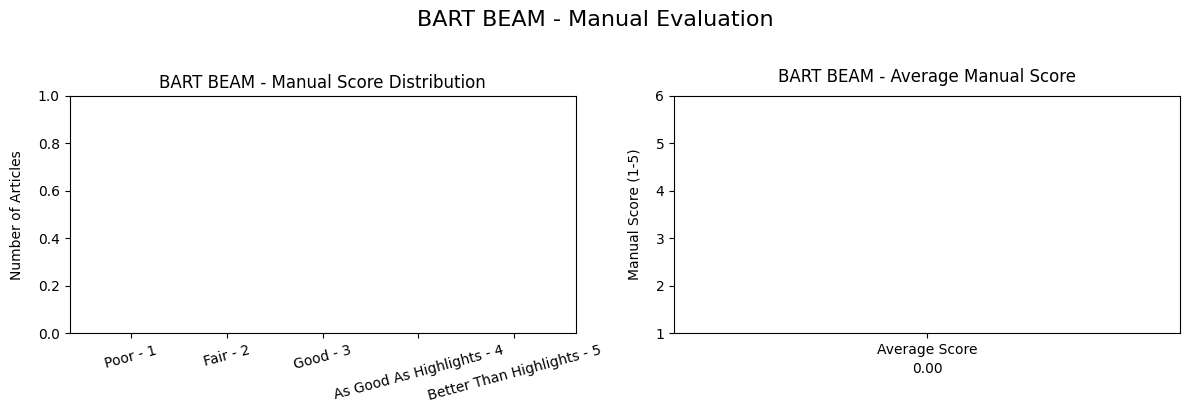

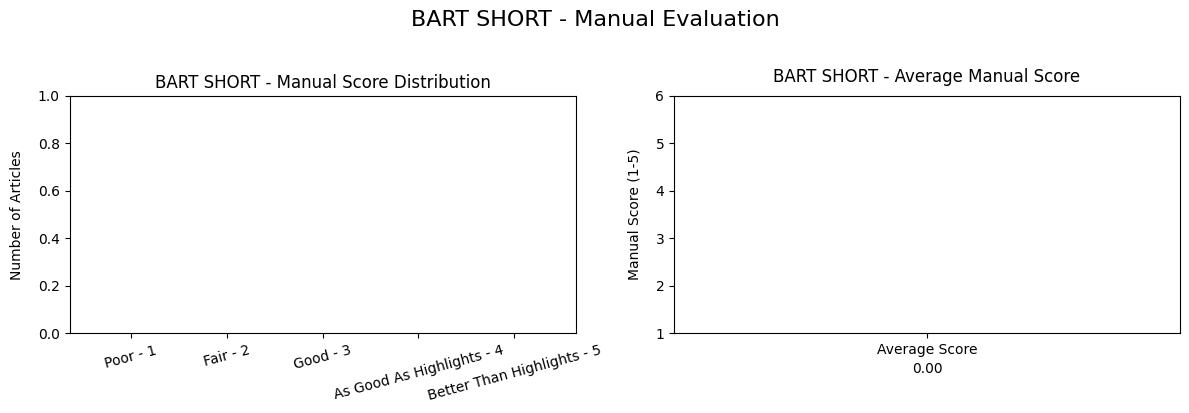

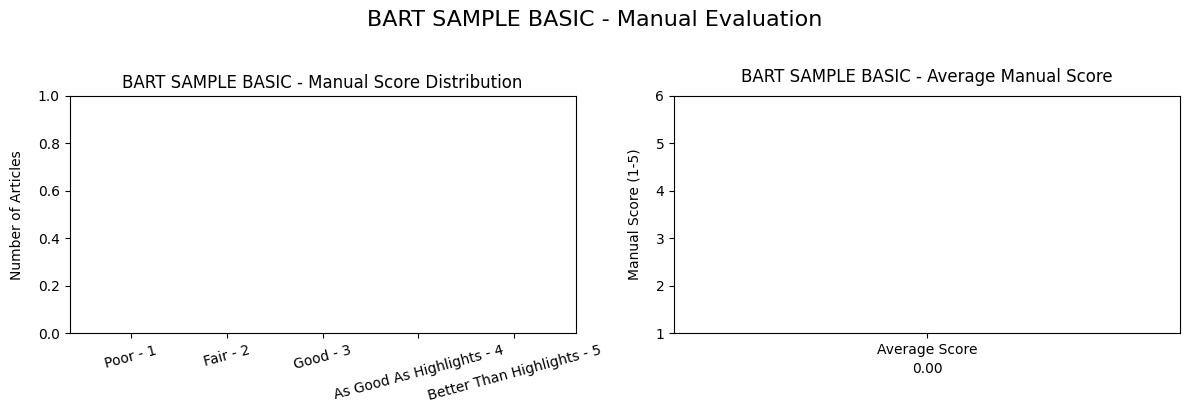

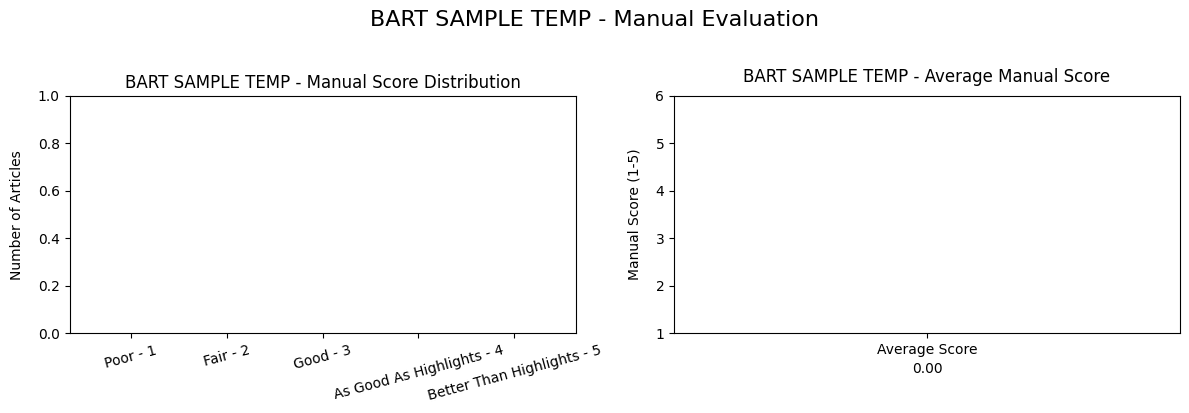

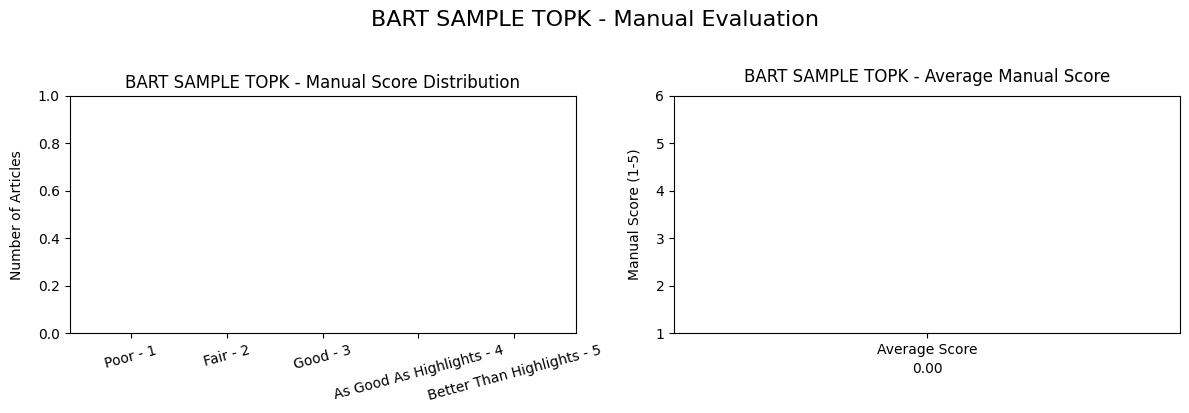

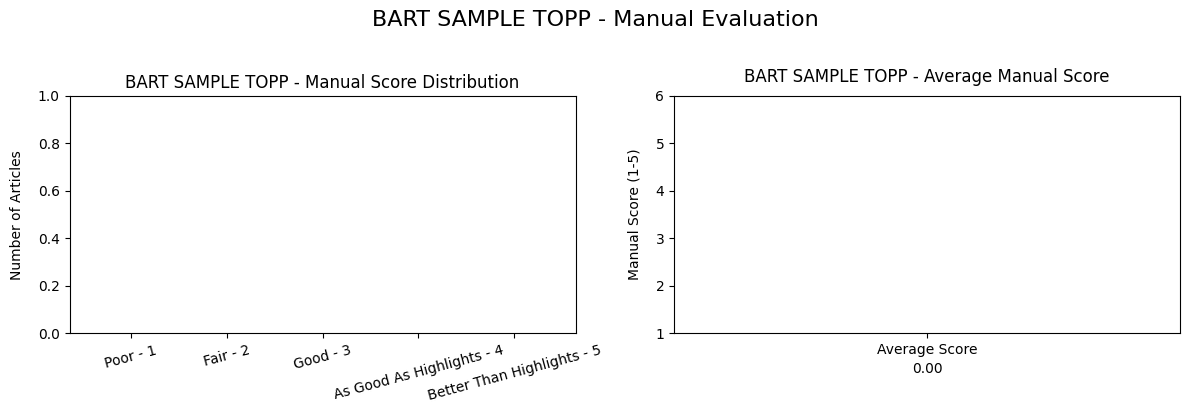

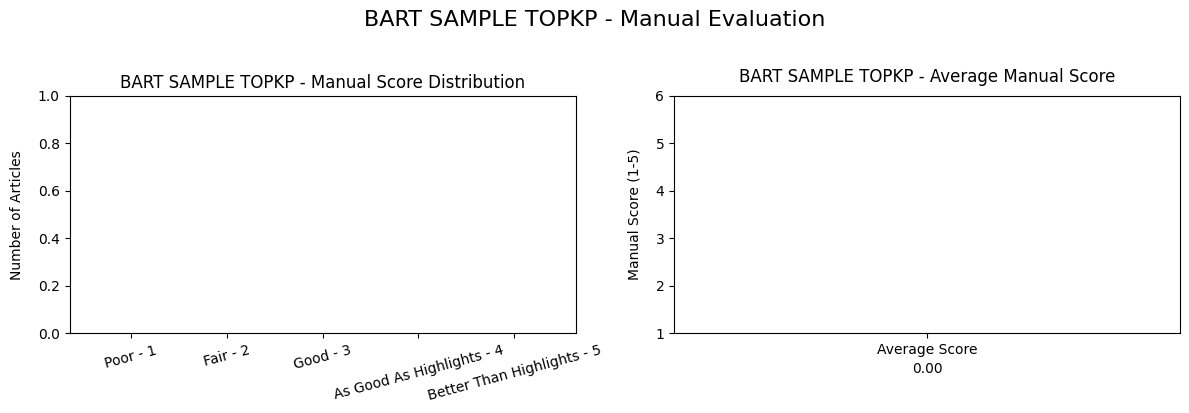

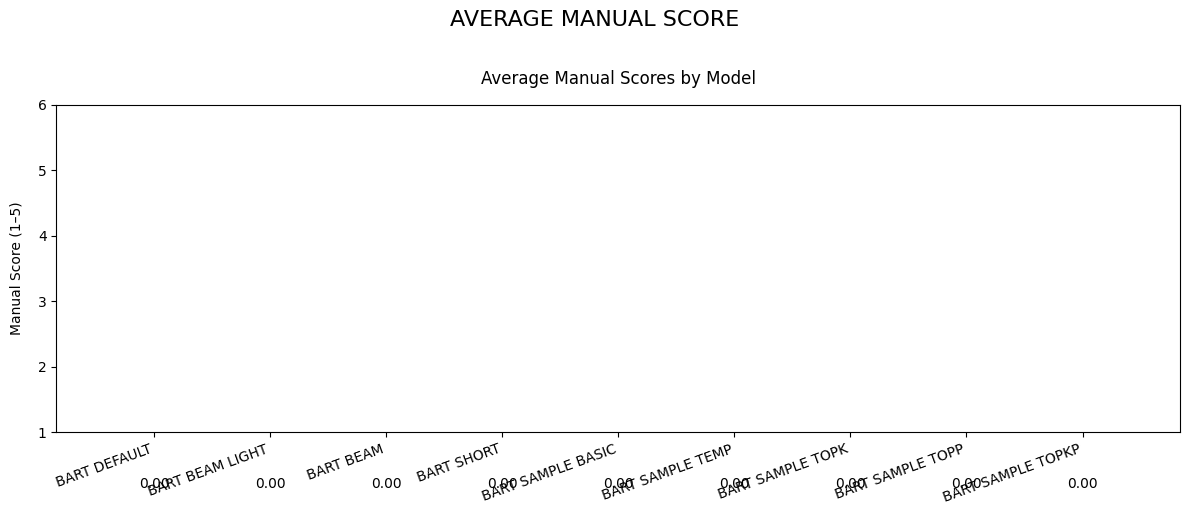

In [34]:
# Plot ablation models
bart_default_evaluator.plot('BART DEFAULT', save_path=os.path.join(results_dir, 'bart_default'))
bart_beam_light_evaluator.plot('BART BEAM LIGHT', save_path=os.path.join(results_dir, 'bart_beam_light'))
bart_beam_evaluator.plot('BART BEAM', save_path=os.path.join(results_dir, 'bart_beam'))
bart_short_evaluator.plot('BART SHORT', save_path=os.path.join(results_dir, 'bart_short'))
bart_sample_basic_evaluator.plot('BART SAMPLE BASIC', save_path=os.path.join(results_dir, 'bart_sample_basic'))
bart_sample_temp_evaluator.plot('BART SAMPLE TEMP', save_path=os.path.join(results_dir, 'bart_sample_temp'))
bart_sample_topk_evaluator.plot('BART SAMPLE TOPK', save_path=os.path.join(results_dir, 'bart_sample_topk'))
bart_sample_topp_evaluator.plot('BART SAMPLE TOPP', save_path=os.path.join(results_dir, 'bart_sample_topp'))
bart_sample_topkp_evaluator.plot('BART SAMPLE TOPKP', save_path=os.path.join(results_dir, 'bart_sample_topkp'))

ablation_avg_manual_scores = {
    'bart_default': bart_default_evaluator.avg_score,
    'bart_beam_light': bart_beam_light_evaluator.avg_score,
    'bart_beam': bart_beam_evaluator.avg_score,
    'bart_short': bart_short_evaluator.avg_score,
    'bart_sample_basic': bart_sample_basic_evaluator.avg_score,
    'bart_sample_temp': bart_sample_temp_evaluator.avg_score,
    'bart_sample_topk': bart_sample_topk_evaluator.avg_score,
    'bart_sample_topp': bart_sample_topp_evaluator.avg_score,
    'bart_sample_topkp': bart_sample_topkp_evaluator.avg_score,
    
}

plot_avg_manual_score(ablation_avg_manual_scores, save_path=os.path.join(results_dir, 'ablation_avg_manual_scores'))